# Control and Simulation of Rocket Hopper Demonstrator

## Target Description
Target: Controlling the altitude by controlling the thrust (the nozzle inlet pressure) of the cold gas-powered Hopper.\
For a SISO system:\
Control input (SI): main valve downstream pressure\
Control variable (SO): altitude of the vehicle

Tasks:
1. Implementation of a simulation environment (digital twin) to simulate the Hopper dynamics
and test the controller in a safe environment
2. Synthesize the control law in the simulation environment
3. Evaluate the controller against the provided criteria and requirements 
4. Deploying and testing the control algorithm on the Hopper (if criteria and requirements are
fulfilled)
5. Comparing and analysing the control performance in the simulation environment vs. reality
6. Summarising the project work in a paper-style report

Requirements:
1. The dynamic model of the hopper has to be comprehensible; reasonable assumptions have
to be made to reduce the system to a degree that allows for comparability between the
simulated system and the real system.
2. The numerical integrator must adequately simulate the mathematical model; it must ensure
that the numerical integrator does not exhibit unstable behaviour, and the numerical
integration error is small. This can be shown by a convergence study. .
3. The controller must be executable in real-time. A minimum of 10Hz must be achieved.
4. The controller must be able to stabilize the hopper at three different altitudes. If a steady-
state value is not attained (e.g., instead, there is a continuous oscillation/limit cycle), it must
be justifiable that this will not pose a risk to the real system.
5. The controller has to be robust enough to stabilize the syste


## Main Components

1. Hose inlet              :  $p_s$ (pressure supply, assume that it is fixed)
2. Hose (inductor+resistor):  $p_1$ (outlet),  $\dot{m}_1$ (inlet)
3. Fitting (resistor)      :  $p_2$ (outlet),  $\dot{m}_2$ (inlet)
4. Main Valve (capacitor)  :  $p_3$ (outlet),  $\dot{m}_3$ (inlet)
5. Nozzle inlet            :  $p_3$,  $\dot{m}_4$
6. Nozzle exit             :  $p_e$


Note: SI (control input) is $p_4$\
Final output SO (altitude of the car): $h_{car}$

In [27]:
# Required Packages
import numpy as np
import matplotlib.pyplot as plt
from mpccontroller import MPCController


###########################################################

# Parameter Setup
# Integration parameter 
h=1/200  # step size    need at least 1000hz (sec)
t0=0    # initial time (sec)
tf=10   # final time (sec)

time=np.linspace(t0,tf,int((tf-t0)/h)+1)

## States
#1. Hose / 2. Fitting /3. Main Valve/4. Nozzle
# Initial pressure (Pa)
p_s=11e5            #p_s pressure supply: at the inlet of the hose   
p1_t0=p_s           # inlet of the fitting
p2_t0=p_s           # inlet of the valve
p3_t0=1e5           # inlet of the nozzle:  assume initial constant air pressure
p3_max_range=11*1e5       # maximum input command for the valve

p3_u_t0=1e5
# Initial mass flow rate (kg/s)
md1_t0=0
md2_t0=0
md3_t0=0
md4_t0=0

state_t0=np.array([p1_t0,md1_t0,p2_t0,md2_t0,p3_t0,md3_t0,p3_u_t0,md4_t0])
state_t=np.zeros((len(state_t0),len(time)))


# Initial density (assuming nitrogen at T=273K)
rho_1_t0 = 1.2336 * p_s / 1e5
rho_2_t0 = 1.2336 * p1_t0 / 1e5
rho_3_t0 = 1.2336 * p2_t0 / 1e5


rho_t0=np.array([rho_1_t0,rho_2_t0,rho_3_t0])
rho_t=np.zeros((len(rho_t0),len(time)))
###########################################################
# Motion (dynamic system)
x_t0=0.0
v_t0=0.0
a_t0=0.0

x_target=4.0         # height target [m]

motion_t0=np.array([x_t0,v_t0])
motion_t=np.zeros((len(motion_t0),len(time)))


###########################################################
# System & environmental parameters

## Hose
H_l=8                  # length [m]
H_d=19.3e-3            # inner diameter[m]
L_1=8                  #  [m]
A_1=np.pi*(H_d/2)**2   # [m^2]
V_1=L_1*A_1                # [m^3] A_1*H_l  


## Fitting
F_l=49e-3                      # length [m]
F_d=11.9e-3                    # diameter [m]
A_2=np.pi*(F_d/2)**2           #[m^2]
V_2=A_2*F_l                    #[m^3] #A_2*F_l


## Main Valve
Kv=4.8 
Open_t=825e-3    # opening time [s]
Close_t=1700e-3  # closing time[s]
T_3=273          # [K]


## Nozzle
Th_d=9e-3                        # throat diameter [m]
Th_exit_d=11e-3                  # exit diameter [m]
A_throat=np.pi*(Th_d/2)**2      #[m^2]
A_e=np.pi*(Th_exit_d/2)**2      #[m^2]
epsilon=A_e/A_throat           #expansion ratio
T_4=273                        #[k]


###########################################################

## mass
m_hop=3.5    # mass of hopper [kg]
m_hose=1.0     # mass of hose   [kg]
prev_pose=x_t0  # for hose dynamic modeling
k_hose=6     # variable hopper mass [N/m]
F_RR=10      # rolling resistence [N]

## constant
R_gas=8314            # universal gas constant [J/kmol*K]
M=28.013           # nitrogen gas  [kg/kmol]
gamma=1.4          # ratio of specific heats (diatomic gas)
g=9.81             # [m/s^2]


f=0.0072                   #  f=0.316/Re^0.25  # darcy friction factor, assuming nitrogen gas flow rate of 1kg/s 
# Re=4*dotm/(\mu * pi* D(diameter))  dynamic viscosity is assume to be 1.76x10^-5 [Pa*s] 20 degree C and 1 atm 
lam_1=f*L_1/H_d                                 # lam_1=f*L_1/H_d  #for hose
lam_2=lam_1*(H_d/L_1)*(F_l/F_d)                 # for fitting, since lambda=f*L/D, proportional to Length and Diameter
###########################################################

# For Kv convert
rho_nitro=1.2336            # [kg/Nm^3 (normal cubic meter)]

In [36]:
## Calculate the basic force 

md4n_term=A_throat/np.sqrt(T_4*R_gas/(M*gamma)) * np.power((gamma+1)/2, -(gamma+1)/(2*(gamma-1)))
ve_term=(2*gamma*R_gas*T_4)/(gamma-1)/M

ve_suggest_val=float(np.sqrt(ve_term * (1 - np.power(0.1615, (gamma - 1) / gamma))))
print("ve_suggest_value:", ve_suggest_val)

thrust_req= m_hop*(g)+k_hose*x_target
pressure_req=thrust_req/(ve_suggest_val*md4n_term)

print("Basic force need to sustain horizontal at the equilibrium is: ", thrust_req ," [N]")
print("Basic pressure command to reach equilibrium at target", x_target, ":", pressure_req, " [Pa]")

######################################################################
## For MPC parameter
Q=np.array([[10.0,0.0],[0.0,10.0]])
R=np.array([0.01])
rho=np.array([0.1])    #damping term (not used right now)
Qf=10*Q
N=50

# initial input
u0=np.array([1e5]).reshape(-1,1)
z0=np.array([0.0,p3_t0]).reshape(-1,1)              #md4n pe

#target state
xs=np.array([x_target,0.0,pressure_req]).reshape(-1,1)           # x v
x0=np.array([motion_t0[0],motion_t0[1]]).reshape(-1,1)
mpc=MPCController(motion_t0,u0,z0,Q,R,Qf,rho,xs,20,N)  # 20Hz
mpc.setup()

ve_suggest_value: 479.88291219746293
Basic force need to sustain horizontal at the equilibrium is:  58.335  [N]
Basic pressure command to reach equilibrium at target 4.0 : 794337.8544538543  [Pa]


(Function(solver:(x0[254],p[4],lbx[254],ubx[254],lbg[204],ubg[204],lam_x0[254],lam_g0[204])->(x[254],f,g[204],lam_x[254],lam_g[204],lam_p[4]) IpoptInterface),
 Function(f:(states[2],alg_states[2],control)->(ode[2],alg[2]) SXFunction))

In [29]:
######################################################################
# Derive exit Mach number (for calculating the pressure ratio, iterative solver)

def solveMe(epsilon,gamma):
    i=0
    Me=1.0
    h=0.1
    maxiter=100
    epsilonest=1.0                #initial estimation
    error=epsilonest-epsilon
    alpha=0.5
    
    while i<=maxiter and np.abs(error)>1e-5:
    
        epsilonest=1/Me*np.power(2/(gamma+1)*(1+(gamma-1)/2*Me**2),(gamma+1)/2/(gamma-1))
        error=epsilonest-epsilon
        
        if np.abs(error) <h:
            h=h*alpha
        
        if error<0:
            Me=Me+h

        elif error>0:
            Me=Me-h      
        
        i=i+1
        
        print("at iteration",i,", Me:",Me, ", and h:", h, ", and epsilon:", epsilonest)

    return Me

Me=solveMe(epsilon,gamma)    # exhaust mach number

print("for comparison, real epsilon: ",epsilon)

at iteration 1 , Me: 1.1 , and h: 0.1 , and epsilon: 1.0
at iteration 2 , Me: 1.2000000000000002 , and h: 0.1 , and epsilon: 1.0079253409090911
at iteration 3 , Me: 1.3000000000000003 , and h: 0.1 , and epsilon: 1.03043975308642
at iteration 4 , Me: 1.4000000000000004 , and h: 0.1 , and epsilon: 1.0663045192307696
at iteration 5 , Me: 1.5000000000000004 , and h: 0.1 , and epsilon: 1.1149257142857145
at iteration 6 , Me: 1.6000000000000005 , and h: 0.1 , and epsilon: 1.1761670524691359
at iteration 7 , Me: 1.7000000000000006 , and h: 0.1 , and epsilon: 1.2502350000000004
at iteration 8 , Me: 1.8000000000000007 , and h: 0.1 , and epsilon: 1.3376063970588243
at iteration 9 , Me: 1.8500000000000008 , and h: 0.05 , and epsilon: 1.4389820576131698
at iteration 10 , Me: 1.8250000000000008 , and h: 0.025 , and epsilon: 1.4951941163429059
at iteration 11 , Me: 1.8500000000000008 , and h: 0.025 , and epsilon: 1.4666150455338995
at iteration 12 , Me: 1.8375000000000008 , and h: 0.0125 , and epsil

In [30]:
## PID parameters for valve control (for the simulation purpose, don't deploy in the real test)
v_kp=2.0   #2.0
v_ki=0.0
v_kd=0.15

v_lasterr=0.0
v_integral=0.0

In [31]:
###########################################################
# for valve

def Kvconvert(T,K_v,p_1,p_2):
    # in here p1 p2 in bar (/1e5)
    """
    Calculates mass flow rate [kg/s] for Nitrogen.
    p1, p2: Inlet/Outlet pressure in Pascal (converted to bar absolute internally +1e5)
    T: Upstream temperature in Kelvin
    """

    p_1=p_1/1e5+1
    p_2=p_2/1e5+1

    #print("in the Kv convert") 
    #print("p1 and p2",p_1," ",p_2)

    if p_2==p_1:
       return 0.0

    if p_2!=p_1:
      if p_2/p_1>=0.528:
         dp=p_1-p_2                                                   # subcritical flow
         Q_N=K_v*514*np.sqrt((dp*p_2)/(rho_nitro*T))    #Nm^3/h: normal cubic meters per hour
      else:                                               # supercritical
         Q_N=K_v*(257*p_1)/np.sqrt(rho_nitro*T)
         #print("superciritcal")

    dotm=(Q_N*rho_nitro)/3600
   
    
    return dotm

###########################################################
# some constants for stateupdate function (de laval nozzle)

pe_term=1/np.power(1+((gamma-1)/2*Me**2), gamma/(gamma-1)) 
print("pe_term:", pe_term)

md4n_term=A_throat / np.sqrt(T_4*R_gas/(M*gamma)) * np.power((gamma+1)/2, -(gamma+1)/(2*(gamma-1)))
print("md4n_term:", md4n_term)

ve_term=(2*gamma*R_gas*T_4)/(gamma-1)/M
print("ve_term:", ve_term)


ve_suggest_val=float(np.sqrt(ve_term * (1 - np.power(0.1615, (gamma - 1) / gamma))))
print("ve_suggest_value:", ve_suggest_val)

###########################################################
# define the RK4 (numerical integrator)

# Butcher Array
RK4matrix=np.array([
      [0,0,0,0],
      [1/4,1/4,0,0],
      [27/40,-189/800,729/800,0],       
      [1,214/891,1/33,650/891],       
      [214/891,1/33,650/891,0],      
   ])


def rk4_ex(f,t,x,h,*args):  #*args allows unknown number of arguments
   k1=f(t+h*RK4matrix[0][0],x+h*RK4matrix[0][1],*args)
   k2=f(t+h*RK4matrix[1][0],x+h*k1*RK4matrix[1][1],*args)
   k3=f(t+h*RK4matrix[2][0],x+h*k2*RK4matrix[2][1],*args)
   k4=f(t+h*RK4matrix[3][0],x+h*k3*RK4matrix[3][1],*args)

   xnext=x+h*(k1*RK4matrix[4][0]+k2*RK4matrix[4][1]+k3*RK4matrix[4][2]+k4*RK4matrix[4][3])
   return xnext

###########################################################
## ODE functions

def capacitor(t,p0,K0,V0,rho_0,md_0,md_1):   
   return K0/(V0*rho_0)*(md_0-md_1)                              # p_dot

                                               
def inductor(t,md0,p_0,p_1,lam,rho_0,A,L):                        #md1,h,t,p1,p2,lam_1,rho_1,A_1,L_1
   return (p_0-p_1 -lam/(2*rho_0*A**2)*md0**2*np.sign(md0))*A/L   #md1 dot

def dx(t,motion,dotm,ve,*args):
   xdot=motion[1]
   xdotdot=dotm*ve/m_hop-g-F_RR/m_hop*np.tanh(motion[1])-k_hose*motion[0]/m_hop  # the last term (hose) assumes that the hose become the damping term

   return np.array([xdot,xdotdot])



###########################################################
# main update function

def stateupdate(t,h,x,rho,motion,nozzle_state,v_pos):
   global v_lasterr, v_integral

   def getK(p):
      return p*gamma
   
   def get_rho(p_t1,p_t2,rho_1):              # get density from adiabatic relation
      return rho_1*np.power(p_t1/p_t2,1/gamma)  # careful
  
   # states
   p1=x[0]
   md1=x[1]
   p2=x[2]
   md2=x[3]
   p3=x[4]
   md3=x[5]
   p3_u=x[6]
   md4=x[7]


   # motions
   x=motion[0]
   v=motion[1]

   #get K
   K1=getK(p1)
   K2=getK(p2)

   #get density
   rho_1=rho[0]
   rho_2=rho[1]
   rho_3=rho[2]

   pe=float(nozzle_state[0])
   ve=float(nozzle_state[1])

   alg_state=np.array([md4,pe])

   ###########################################################
   # Algebraic Equation  (note: equations with "dot" use RK4)
   
   # Hose (inductor / capacitor)
   md1n=rk4_ex(inductor,t,md1,h,p_s,p1,lam_1,rho_1,A_1,L_1)   # rk4_ex rules: t,x,h, *args
   p1n=rk4_ex(capacitor,t,p1,h,K1,V_1,rho_1,md1,md2)                                      

   # Fitting (resistor)
   md2n=md3                                                            # assuming the same mass flow rate as md3
   p2n=p1-lam_2/(2*rho_2*A_2**2)*md2**2*np.sign(md2)                   # resistor equation

   # Main Valve 
   md3n=Kvconvert(T_3,Kv,p2,p3)                                # Kvconvert 

   # Nozzle
   p3_u=mpc.compute_action(x0=np.array(motion).reshape(-1,1),z0=np.array(alg_state).reshape(-1,1),xs=np.array([x_target,0.0]).reshape(-1,1),u0=np.array(p3_u))
   # control input  (introduce the time delay modify once imply the controller)
   
   #####################################################################
   # introduce the actuator delay and PID controller for valve (only use the PD controller actually)
   v_u=(p3_u-1e5)/p3_max_range
   v_u=np.clip(v_u,0,1)          # restrict the valve command to between 0,1 

   v_error=v_u-v_pos
   #PID controller for valve (Note: The overall system is a cascaded PID control loop: pressure command + valve control)
   v_integral +=v_error*h
   v_adjustment = v_kp* v_error

   if v_adjustment>0:                 # opening lag
      max_valve_speed=1.0/Open_t
      min_valve_speed=0.0

   elif v_adjustment<0:               # closing lag
      max_valve_speed=0.0
      min_valve_speed=-1.0/Close_t
   else:                         # same input (not closing/opening)
      max_valve_speed=0.0
      min_valve_speed=0.0

   v_lasterr=v_error
   v_speed_actual=np.clip(v_adjustment,min_valve_speed, max_valve_speed)

   v_pos=v_pos+h*v_speed_actual
   v_pos=np.clip(v_pos,0,1)      # restrict the valve position to between 0,1   
   #####################################################################
   p3_actual=v_pos*p3_max_range+1e5

   md4n=A_throat*p3_actual/(np.sqrt(T_4*R_gas/(M*gamma)))*np.power((gamma+1)/2,-(gamma+1)/(2*(gamma-1)))  # m_choked (at choked condition)

   if md4n>md3n:
      print("warning !! flow is not choked!!")
  

   # Nozzle exit
   pe=p3_actual/np.power(1+((gamma-1)/2*Me**2), gamma/(gamma-1))                         #exit pressure
   ve=np.sqrt((2*gamma*R_gas*T_4)/(gamma-1)/M*(1-np.power(pe/p3_actual,(gamma-1)/gamma)))    #exit velocity
   
   # update the motion
   motion_n=rk4_ex(dx,t,motion,h,md4n,ve)                       # we have to assume the flow to be choked or else ve will not be constant
   # if we haven't increase the height, restrict to zero
   if motion_n[0]<0:
      motion_n[0]=0.0

   ###########################################################

   rho_1n=rho_1                          # as the pressure at the supply assumed to be fixed, it won't change
   rho_2n=get_rho(p1,p1n,rho_2)
   rho_3n=get_rho(p2,p2n,rho_3)

   
   #print(" p3_u ",p3_u, " v_pos", v_pos, " p3_actual",p3_actual,"v_u",v_u, " v_speed_actual", v_speed_actual)
   #print("p1n: ",p1n, " p2n ",p2n," p3_actual ",p3_actual," md1n ",md1n," md2n ",md2n," md3n ",md3n, " v_pos ",v_pos)
   #print("rho_1n ",rho_1n," rho_2n ",rho_2n," rho_3n ",rho_3n)


   return [p1n,md1n,p2n,md2n,p3_actual,md3n,p3_u,md4n],[rho_1n,rho_2n,rho_3n],motion_n,[pe,ve],v_pos



pe_term: 0.16153413886518198
md4n_term: 1.5303425617273556e-07
ve_term: 567167.1723842502
ve_suggest_value: 479.88291219746293


In [37]:
# main iteration loop

# initialize the state at each time stamp
state_ti=state_t0
rho_ti=rho_t0
motion_ti=motion_t0
nozzle_st=[p3_t0,0]
v_pos=0.0



for ti in range(len(time)-1):
    #
    t=time[ti]

    #store the step
    state_t[:,ti]=state_ti
    rho_t[:,ti]=rho_ti
    motion_t[:,ti]=motion_ti

    # calculte the new value (RK4/Algebraic update)
    state_ti,rho_ti,motion_ti,nozzle_st,v_pos=stateupdate(t,h,state_ti,rho_ti,motion_ti,nozzle_st,v_pos)


    #print("p1 ",state_ti[0]," p2: ",state_ti[2]," p3: ",state_ti[4])
    #print("md1 ",state_ti[1]," md2: ",state_ti[3]," md3: ",state_ti[5]," md4: ",state_ti[6])
    #print("x: ", motion_t[0,ti])

    #print(f'Step {t} of {len(time)-1}'.format())

print("final position", motion_ti[0]," final velocity",motion_ti[1])    

final position 3.992256445965904  final velocity 0.0003164080811209573


state_t 793768.4052724816


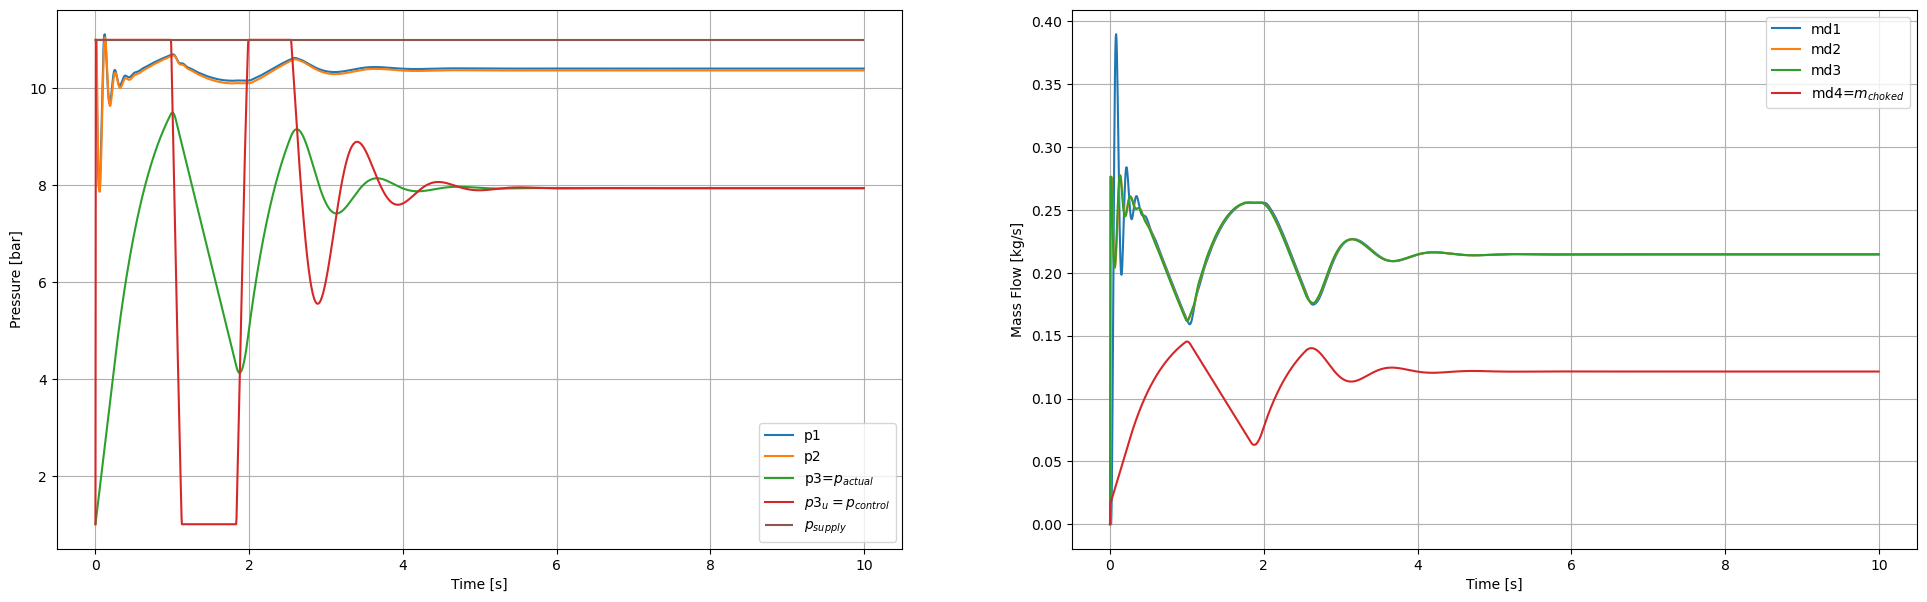

In [45]:
# Visualization

# part 1: pressure and mass flow rate

fig_p=plt.figure(figsize=(24,7))
plt.subplot(121)
plt.plot(time[:-1], state_t[0, :-1]/1e5, label='p1', color='C0')
plt.plot(time[:-1], state_t[2, :-1]/1e5, label='p2', color='C1')
plt.plot(time[:-1], state_t[4, :-1]/1e5, label='p3=$p_{actual}$', color='C2')
plt.plot(time[:-1], state_t[6, :-1]/1e5, label='$p3_u=p_{control}$', color='C3')
plt.hlines(p_s/1e5,xmin=0,xmax=tf,label='$p_{supply}$', color='C5')
plt.xlabel('Time [s]')
plt.ylabel('Pressure [bar]')
# plt.ylim(ymin=9.99999, ymax=10.00001)
plt.grid()
plt.legend()

plt.subplot(122)
plt.plot(time[:-1], state_t[1, :-1], label='md1', color='C0')
plt.plot(time[:-1], state_t[3, :-1], label='md2', color='C1')
plt.plot(time[:-1], state_t[5, :-1], label='md3', color='C2')
plt.plot(time[:-1], state_t[7, :-1], label='md4=$m_{choked}$', color='C3')
plt.xlabel('Time [s]')
plt.ylabel('Mass Flow [kg/s]')
plt.grid()
plt.legend()
# the ideal value for p2 is suppose to be around 10 bar
print("state_t",state_t[4,-2])


fig_p.savefig("../figure/mpc_pressure.png")

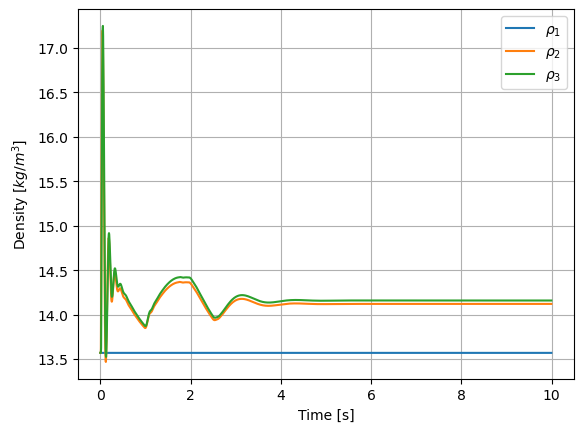

In [34]:
# part 2: density

plt.plot(time[:-1], rho_t[0, :-1], label= r'$\rho_1$',color='C0')
plt.plot(time[:-1], rho_t[1, :-1], label=r'$\rho_2$', color='C1')
plt.plot(time[:-1], rho_t[2, :-1], label=r'$\rho_3$', color='C2')
plt.xlabel('Time [s]')
plt.ylabel('Density [$kg/m^3$]')
plt.grid()
plt.legend()


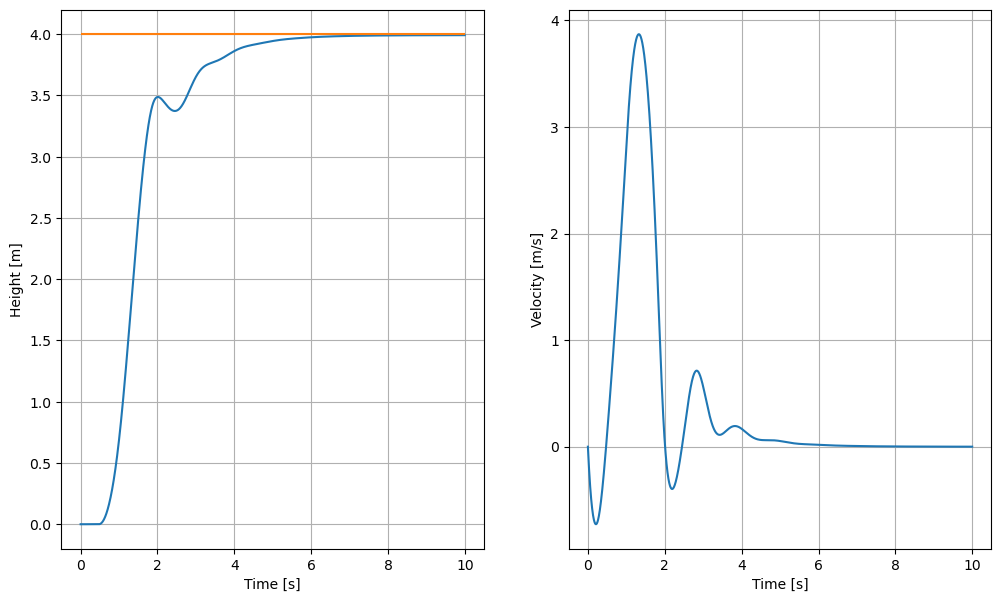

In [44]:
# part 3: motion
fig_m=plt.figure(figsize=(12,7))
plt.subplot(121)
plt.plot(time[:-1], motion_t[0, :-1], label='x',color="C0")
plt.hlines(x_target,xmin=0,xmax=tf,label="target",colors="C1")
plt.xlabel('Time [s]')
plt.ylabel('Height [m]')
plt.grid()


plt.subplot(122)
plt.plot(time[:-1], motion_t[1, :-1], label='v')
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.grid()


fig_m.savefig("../figure/mpc_motion.png")